#Constructive Loss

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split

# Download LFW dataset
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Dataset path:", path)

MAX_IMAGES = 2000  # Load only 1000 images

def load_lfw_dataset(dataset_path, max_images=MAX_IMAGES):
    images = []
    labels = []
    label_dict = {}
    current_label = 0
    count = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                if count >= max_images:
                    break
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (128, 128)) / 255.0

                    person_name = os.path.basename(root)
                    if person_name not in label_dict:
                        label_dict[person_name] = current_label
                        current_label += 1

                    images.append(img)
                    labels.append(label_dict[person_name])
                    count += 1
        if count >= max_images:
            break

    return np.array(images), np.array(labels)

# Load dataset
X, y = load_lfw_dataset("/kaggle/input/lfw-dataset")
print("Loaded images:", X.shape, "Labels:", y.shape)


Dataset path: /kaggle/input/lfw-dataset
Loaded images: (2000, 128, 128, 3) Labels: (2000,)


In [ ]:
x_tem, x_test, y_tem, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_tem, y_tem, test_size=0.2, random_state=42)
print("xtrain_shape", x_train.shape, "ytrain_shape", y_train.shape)
print("xval_shape", x_val.shape, "yval_shape", y_val.shape)
print("xtest_shape", x_test.shape, "ytest_shape", y_test.shape)

xtrain_shape (1440, 128, 128, 3) ytrain_shape (1440,)
xval_shape (360, 128, 128, 3) yval_shape (360,)
xtest_shape (200, 128, 128, 3) ytest_shape (200,)


In [ ]:
import numpy as np
import random
from collections import defaultdict

def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label (0: same class, 1: different class)."""

    x = np.array(x)
    y = np.array(y)

    # Build dictionary: label -> list of indices
    label_to_indices = defaultdict(list)
    for idx, label in enumerate(y):
        label_to_indices[label].append(idx)

    # Filter out labels with less than 2 samples (cannot form pairs)
    label_to_indices = {label: idxs for label, idxs in label_to_indices.items() if len(idxs) > 1}
    valid_labels = list(label_to_indices.keys())
    if len(valid_labels) < 2:
        raise ValueError("Not enough valid classes to make pairs. Need at least 2 classes with >=2 samples.")

    pairs = []
    labels_out = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]

        if label1 not in label_to_indices:
            continue  # skip if not enough samples to make a pair

        # ➤ Positive pair (same class)
        idx2 = idx1
        while idx2 == idx1:
            idx2 = random.choice(label_to_indices[label1])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels_out.append(0)

        # ➤ Negative pair (different class)
        label2 = label1
        while label2 == label1 or label2 not in label_to_indices:
            label2 = random.choice(valid_labels)
        idx2 = random.choice(label_to_indices[label2])
        x2 = x[idx2]
        pairs.append([x1, x2])
        labels_out.append(1)

    return np.array(pairs), np.array(labels_out).astype("float32")

# Generate data
x_train, y_train = make_pairs(x_train, y_train)
x_val, y_val = make_pairs(x_val, y_val)
x_test, y_test = make_pairs(x_test, y_test)

print("Train pairs:", x_train.shape, y_train.shape, "Val pairs:", x_val.shape, y_val.shape, "Test pairs:", x_test.shape, y_test.shape)

Train pairs: (1932, 2, 128, 128, 3) (1932,) Val pairs: (352, 2, 128, 128, 3) (352,) Test pairs: (186, 2, 128, 128, 3) (186,)


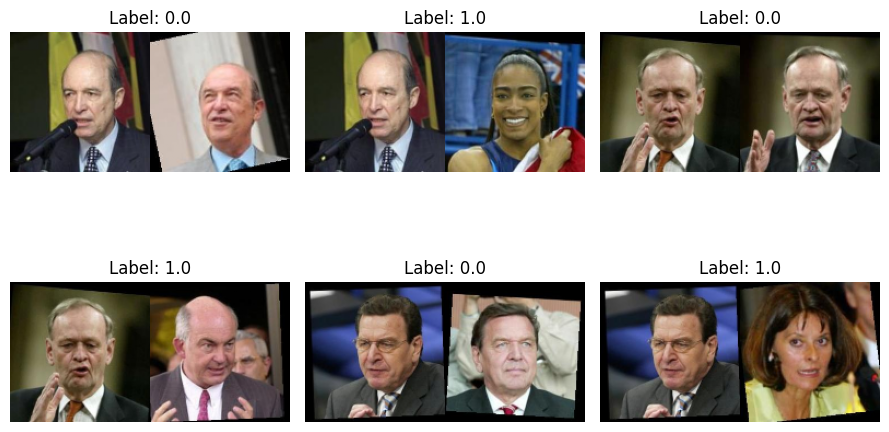

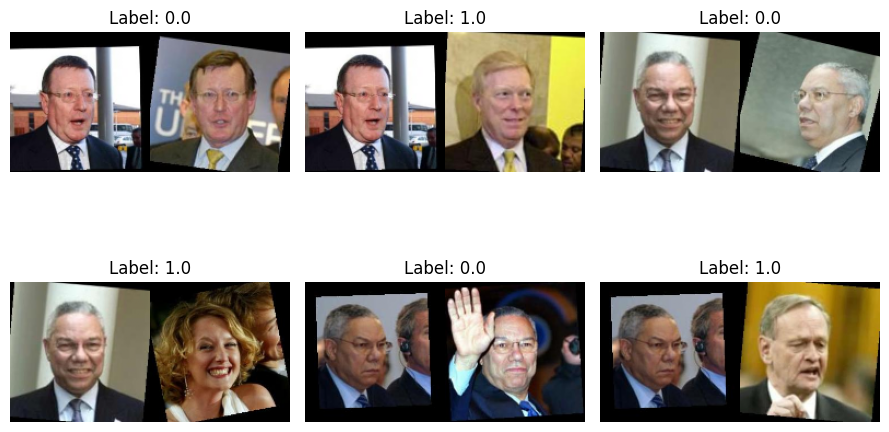

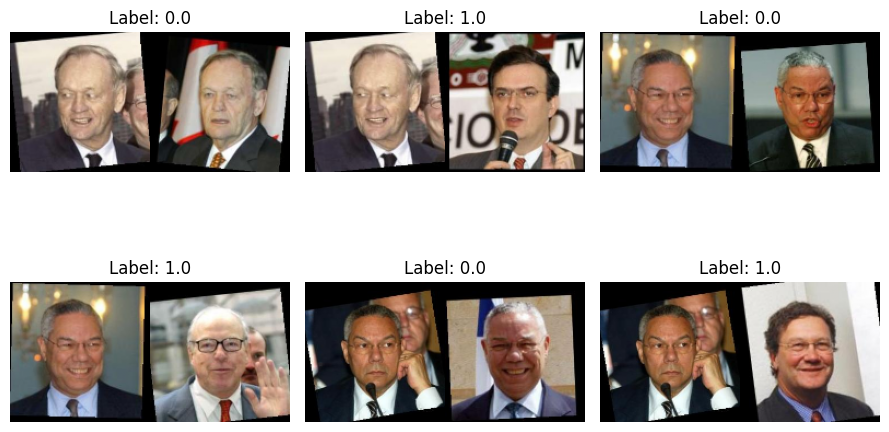

In [ ]:
from keras import ops
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """
    Visualizes image pairs and labels/predictions for RGB face dataset.

    Arguments:
        pairs: numpy array with shape (num_pairs, 2, H, W, 3)
        labels: true labels (0=same, 1=different)
        to_show: how many pairs to display
        num_col: number of columns in the plot
        predictions: model predictions (used when test=True)
        test: flag to display predictions along with labels
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(3 * num_col, 3 * num_row))

    for i in range(to_show):
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        # Concatenate left and right images horizontally
        image_pair = np.concatenate([pairs[i][0], pairs[i][1]], axis=1)
        ax.imshow(image_pair)
        ax.set_axis_off()

        if test and predictions is not None:
            ax.set_title(f"True: {labels[i]} | Pred: {predictions[i][0]:.2f}")
        else:
            ax.set_title(f"Label: {labels[i]}")

    plt.tight_layout()
    plt.show()


visualize(x_train, y_train, to_show=6, num_col=3)
visualize(x_val, y_val, to_show=6, num_col=3)
visualize(x_test, y_test, to_show=6, num_col=3)

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))

import keras
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))


input = keras.layers.Input((128, 128, 3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((128, 128, 3))
input_2 = keras.layers.Input((128, 128, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

margin=1.0
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))


    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 10)        │    190,326 │ input_layer_16[0… │
│ (Functional)        │                   │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ functional_9[0][… │
│                     │                   │            │ functional_9[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 190,332 (743.48 KB)

 Trainable params: 163,412 (638.33 KB)

 Non-trainable params: 26,920 (105.16 KB)

In [ ]:
x_train_1 = x_train[:, 0]
x_train_2 = x_train[:, 1]
x_val_1 = x_val[:, 0]
x_val_2 = x_val[:, 1]
x_test_1 = x_test[:, 0]
x_test_2 = x_test[:, 1]

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_data=([x_val_1, x_val_2], y_val),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5537 - loss: 0.2931 - val_accuracy: 0.5341 - val_loss: 0.3483
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5998 - loss: 0.2453 - val_accuracy: 0.5341 - val_loss: 0.2888
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6506 - loss: 0.2267 - val_accuracy: 0.5966 - val_loss: 0.2615
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6406 - loss: 0.2310 - val_accuracy: 0.5767 - val_loss: 0.2610
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6501 - loss: 0.2217 - val_accuracy: 0.5540 - val_loss: 0.2661
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6324 - loss: 0.2232 - val_accuracy: 0.5994 - val_loss: 0.2431
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6280 - loss: 0.2279 - val_accuracy: 0.6023 - val_loss: 0.2442
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6511 - loss: 0.2188 - val_accuracy: 0.6307 - 

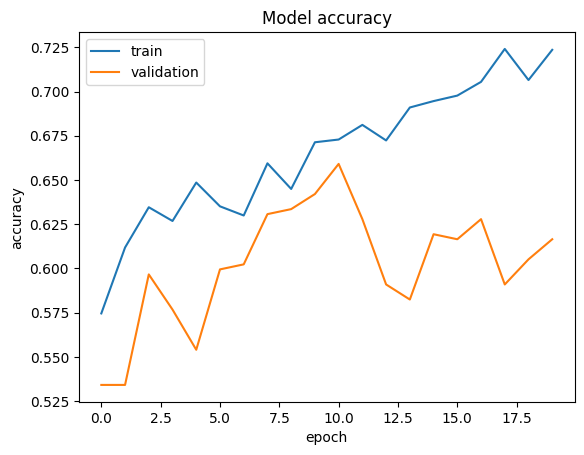

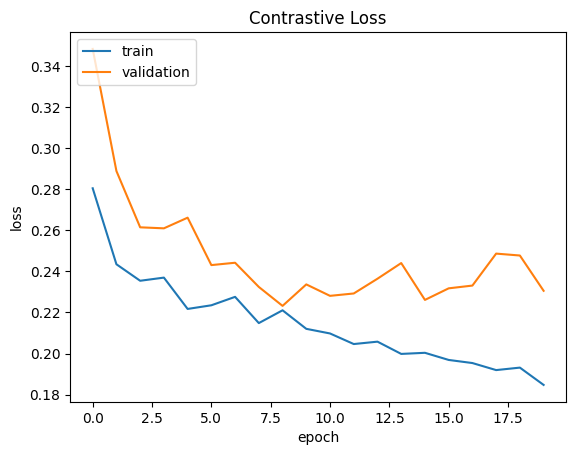

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.7125 - loss: 0.2050
test loss, test acc: [0.21265536546707153, 0.7043010592460632]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


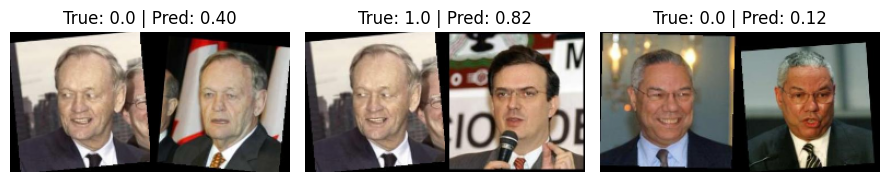

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(x_test, y_test, to_show=3, predictions=predictions, test=True)

#Triplet Loss

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from pathlib import Path

# Set the dataset path
lfw_path = Path("/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled")
target_shape = (200, 200)

# Preprocess a single image
def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image

# Preprocess a triplet of (anchor, positive, negative)
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

# Get all identities with at least 2 images
def get_valid_identities(min_images=2):
    identities = []
    for person in lfw_path.iterdir():
        images = list(person.glob("*.jpg"))
        if len(images) >= min_images:
            identities.append(person)
    return identities

# Build triplet paths (anchor, positive, negative)
def build_triplet_paths(identities, num_triplets=10000):
    anchor_paths, positive_paths, negative_paths = [], [], []

    for _ in range(num_triplets):
        pos_identity = random.choice(identities)
        neg_identity = random.choice(identities)
        while neg_identity == pos_identity:
            neg_identity = random.choice(identities)

        pos_images = list(pos_identity.glob("*.jpg"))
        neg_images = list(neg_identity.glob("*.jpg"))

        if len(pos_images) < 2 or len(neg_images) < 1:
            continue  # skip if not enough images

        anchor, positive = random.sample(pos_images, 2)
        negative = random.choice(neg_images)

        anchor_paths.append(str(anchor))
        positive_paths.append(str(positive))
        negative_paths.append(str(negative))

    return anchor_paths, positive_paths, negative_paths

# Generate triplet file paths
identities = get_valid_identities()
anchor_paths, positive_paths, negative_paths = build_triplet_paths(identities, num_triplets=5000)

# Create TensorFlow Dataset
anchor_ds = tf.data.Dataset.from_tensor_slices(anchor_paths)
positive_ds = tf.data.Dataset.from_tensor_slices(positive_paths)
negative_ds = tf.data.Dataset.from_tensor_slices(negative_paths)

# Zip into triplets
triplet_ds = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))
triplet_ds = triplet_ds.map(preprocess_triplets, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and split
total_count = len(anchor_paths)
train_count = round(total_count * 0.8)

train_dataset = triplet_ds.take(train_count)
val_dataset = triplet_ds.skip(train_count)

# Batch and prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


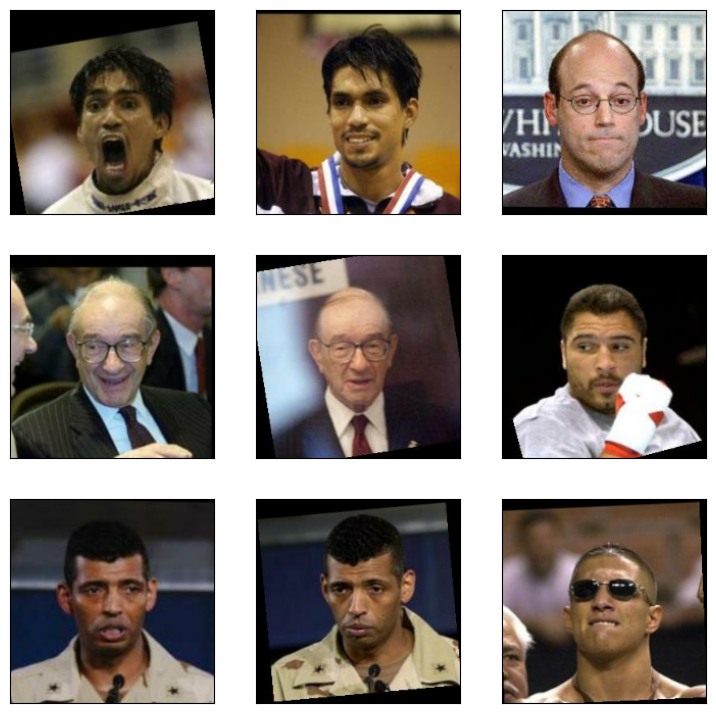

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history=siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 521ms/step - loss: 0.3340 - val_loss: 0.3040
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - loss: 0.2726 - val_loss: 0.2993
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 421ms/step - loss: 0.2199 - val_loss: 0.2943
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - loss: 0.1932 - val_loss: 0.2711
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - loss: 0.1582 - val_loss: 0.2892
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - loss: 0.1363 - val_loss: 0.2871
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 417ms/step - loss: 0.1263 - val_loss: 0.2943
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 419ms/step - loss: 0.1108 - val_loss: 0.2979
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 448ms/step - loss: 0.0980 - val_loss: 0.2865
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 424ms/step - loss: 0.0959 - val_loss: 0.2847
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - loss: 0.0616 - val_loss: 0.2698
Epoch 12/20
125/125

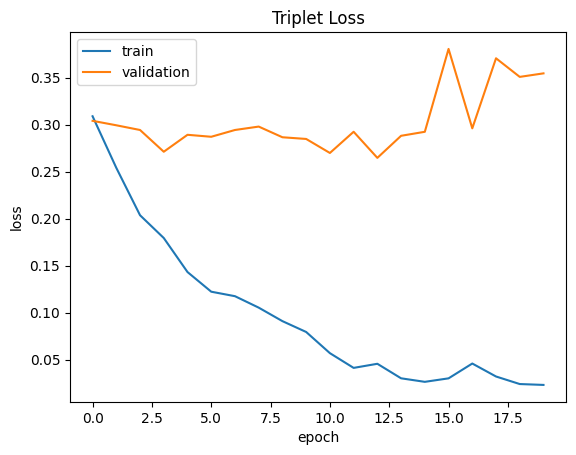

In [ ]:
# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Triplet Loss")

Positive similarity: 0.99945277
Negative similarity 0.99912375


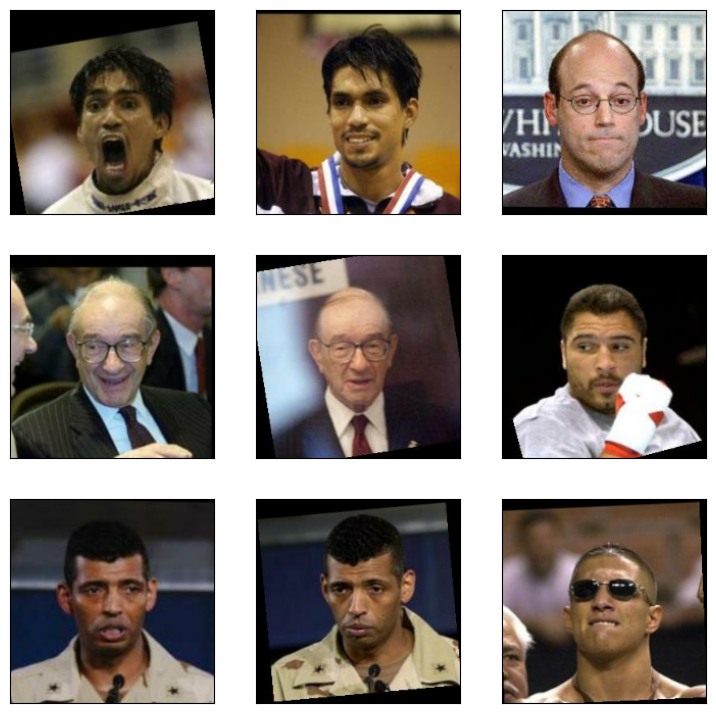

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

#Binary Cross Entropy

In [ ]:
siamese.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(0.0001), metrics=["accuracy"])

history = siamese.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_data=([x_val_1, x_val_2], y_val),
    batch_size=32,
    epochs=20,
)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step - accuracy: 0.7430 - loss: 0.5450 - val_accuracy: 0.6250 - val_loss: 0.6462
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7109 - loss: 0.5551 - val_accuracy: 0.6136 - val_loss: 0.6624
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7547 - loss: 0.5293 - val_accuracy: 0.6165 - val_loss: 0.6633
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7484 - loss: 0.5344 - val_accuracy: 0.6222 - val_loss: 0.6718
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7380 - loss: 0.5312 - val_accuracy: 0.6222 - val_loss: 0.6456
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7642 - loss: 0.5178 - val_accuracy: 0.6222 - val_loss: 0.6405
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7575 - loss: 0.5172 - val_accuracy: 0.6420 - val_loss: 0.6393
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7444 - loss: 0.5101 - val_accuracy: 0.6534 - 

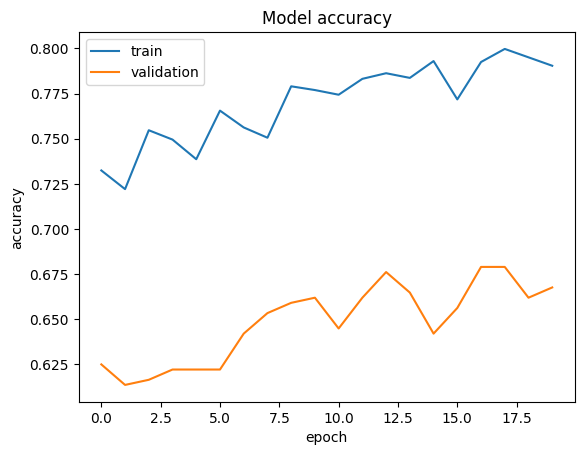

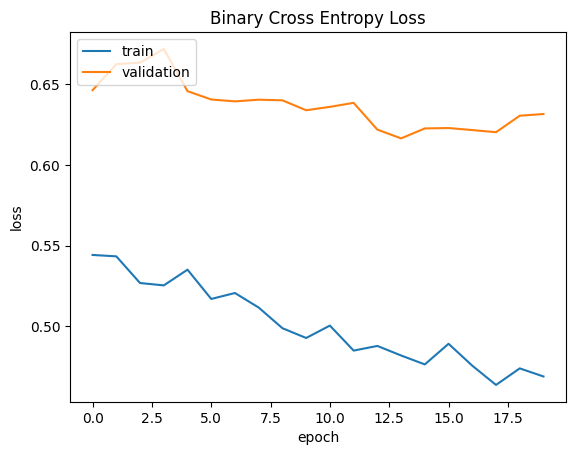

In [ ]:
# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Binary Cross Entropy Loss")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6781 - loss: 0.6185
test loss, test acc: [0.6272056102752686, 0.6774193644523621]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Pair 1:
  True Label: 0.0
  Predicted Prob: 0.2131
  Predicted Label: 0
------------------------------
Pair 2:
  True Label: 1.0
  Predicted Prob: 0.7934
  Predicted Label: 1
------------------------------
Pair 3:
  True Label: 0.0
  Predicted Prob: 0.0805
  Predicted Label: 0
------------------------------
Pair 4:
  True Label: 1.0
  Predicted Prob: 0.5224
  Predicted Label: 1
------------------------------
Pair 5:
  True Label: 0.0
  Predicted Prob: 0.5274
  Predicted Label: 1
------------------------------
Pair 6:
  True Label: 1.0
  Predicted Prob: 0.3728
  Predicted Label: 0
------------------------------
Pair 7:
  True Label: 0.0
  Predicted Prob: 0.2022
  Predicted Label: 0
------------------------------
Pair 8:
  True Label: 1.0
  Predicted Prob: 0.8995
  Predicted Label: 1
------------------------------
Pair

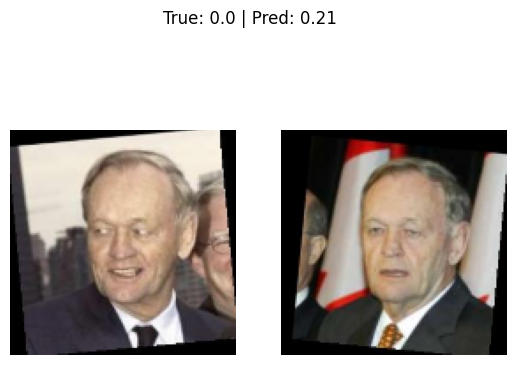

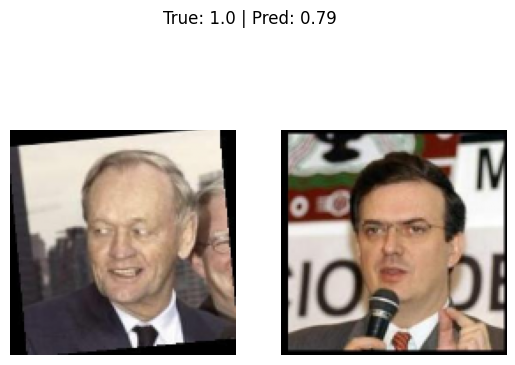

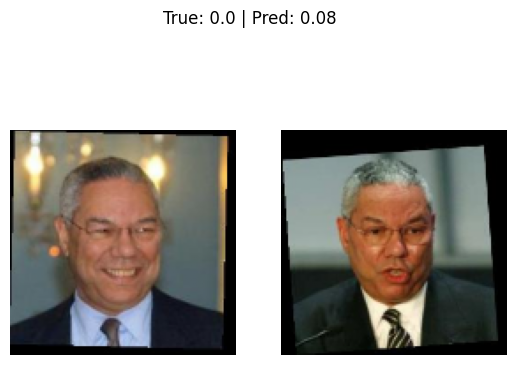

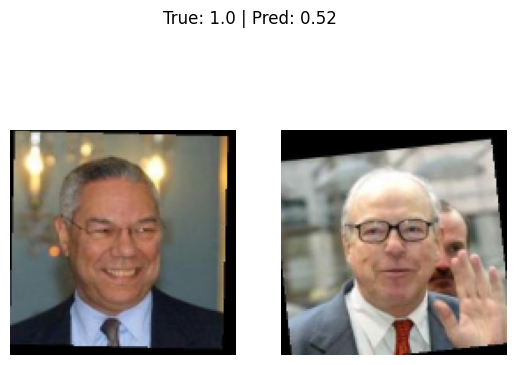

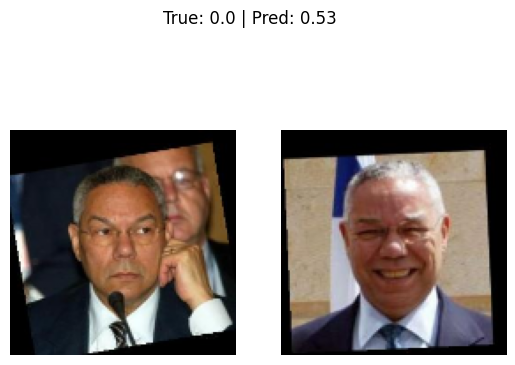

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

# Predict probabilities
predictions = siamese.predict([x_test_1, x_test_2])

# Threshold predictions (e.g., 0.5)
pred_labels = (predictions > 0.5).astype("int")

# Print sample predictions
for i in range(10):
    print(f"Pair {i+1}:")
    print(f"  True Label: {y_test[i]}")
    print(f"  Predicted Prob: {predictions[i][0]:.4f}")
    print(f"  Predicted Label: {pred_labels[i][0]}")
    print("-" * 30)

# Optionally plot a few image pairs
def plot_pair(img1, img2, label, pred):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[0].axis("off")
    ax[1].imshow(img2)
    ax[1].axis("off")
    plt.suptitle(f"True: {label} | Pred: {pred:.2f}", fontsize=12)
    plt.show()

# Show 5 image pairs with predictions
for i in range(5):
    plot_pair(x_test_1[i], x_test_2[i], y_test[i], predictions[i][0])
